<h1><b>Classification on Hand-written Digits Dataset</b></h1>
<h4>Editor: Daniel Wang</h4>

The [UCI ML hand-written digits dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset) is a classic dataset for machine learning beginners to first explore the wonderfulness of classification models. The dataset contains 8x8 images and a corresponded label, and the label values are digit 0 to 9.

<h2><b><u>Data Exploration</u></b></h2>

First, we import some necessary Python libraries:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.datasets import load_digits

Then we load the dataset from *sklearn* package:

In [ ]:
X, y = load_digits(return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

We have 1797 observations, and each observation contains 64 features and 1 label.

Let's see what are the features look like:

0

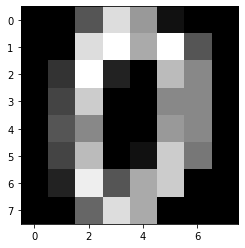

In [ ]:
plt.imshow(X[0].reshape((8,8)), cmap="gray")
y[0]

Next, to see if the class is balanced, let's see its distribution using a histogram plot:

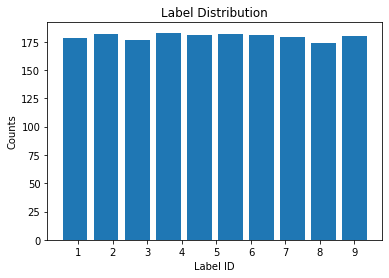

In [ ]:
plt.hist(y, bins=10, rwidth=.8, align="right")
plt.xticks(range(1, 10))
plt.xlabel("Label ID")
plt.ylabel("Counts")
plt.title("Label Distribution")
plt.show()

We can see the class is balanced. Therefore, we don't need to use oversampling methods (e.g. SMOTE, ADASYM), or undersampling methods (e.g. NearMiss, Tomek Links) here.

Since it is a multi-class classification problem, we can use evaluation metrics such as accuracy, precision, recall, and averaged AUROC score. To better evaluate our models in future sections, let's define the evaluation function first:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize

def evaluation(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred, average="weighted")
  recall = recall_score(y_true, y_pred, average="weighted")
  auroc = roc_auc_score(
      label_binarize(y_test, classes=range(10)),
      label_binarize(y_pred, classes=range(10)),
      average="weighted")
    
  print("Accuracy: {:.2f}".format(acc))
  print("Precision: {:.2f}".format(prec))
  print("Recall: {:.2f}".format(recall))
  print("AUROC: {:.2f}".format(auroc))
    
  return confusion_matrix(y_true, y_pred)

This function will print out all the evaluation metrics, and return the confusion matrix. The returned matrix can further be visualized using a heatmap.

Next, we do the train/test split:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train.shape, X_test.shape

((1078, 64), (719, 64))

Where there are 60% of training data and 40% of test data. The reason that I decrease the ratio of training data (traditionally, 70%) is that UCI ML hand-written digits is actually an easy task for most machine learning models. If there are too much training data, the model performance will become close to 100%, which makes us hard to tell which model is better.

After data splitting, we need to rescale our data value, since machine learning models are sensitive to the data scale. We use *StandardScalar* here:

In [ ]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

<h2><b><u>Model 1: LR (Logistic Regression)</u></b></h2>

Logistic Regression is the simplest model, and it takes the sigmoid function to compress the linear regression's outputs into [0, 1]. 

Using the L2 penalty, let's see its performance:

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l2", random_state=0)
lr.fit(X_train_s, y_train)
lr_pred = lr.predict(X_test_s)

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
AUROC: 0.98


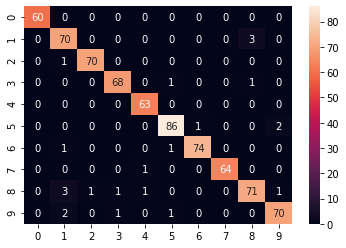

In [ ]:
cmat_lr = evaluation(y_test, lr_pred)
sns.heatmap(cmat_lr, annot=True)
plt.show()

Actually, it already produces descent performance. However, we can note that Logistic Regression sometimes misclassified 1 into 8 or 9, and the reason may due to the messy handwritting style in some cases.

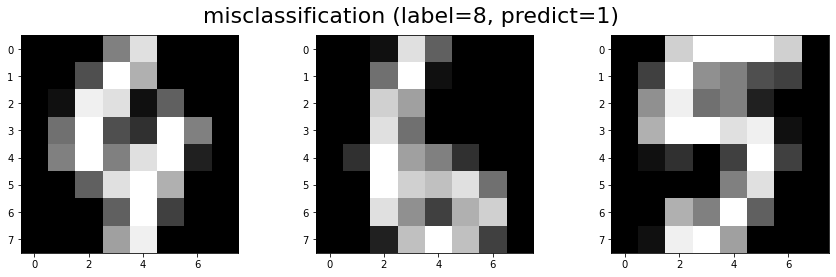

In [ ]:
mis_idx = []
for idx, (t, p) in enumerate(zip(y_test, lr_pred)):
  if t == 8 and p == 1:
    mis_idx.append(idx)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 4)
axes[0].imshow(X[mis_idx[0]].reshape((8, 8)), cmap="gray")
axes[1].imshow(X[mis_idx[1]].reshape((8, 8)), cmap="gray")
axes[2].imshow(X[mis_idx[2]].reshape((8, 8)), cmap="gray")
fig.suptitle("misclassification (label=8, predict=1)", size=22)
plt.show()

We can see the above 3 images has the label "8" in the dataset, yet it's even hard for us to recognize what digits are they with our naked eyes! They seems like 9, 6 and 5, respectively...

Therefore, we shall not totally blame for the prediction of Logistic Regression. However, we may be interested in whether a more sophisticated model could eliminate such misclassified cases? Or generally speaking, could a more complex model even yields higher performance than the Logistic Regression? Let's check it out in the next few sections.

<h2><b><u>Model 2: SVM (Support Vector Machine)</u></b></h2>

SVM model tries to find the support vector that can separate different classes as further as possible. To separate non-linear features, SVM sometimes cooperates with the RBF kernel to map the features to a higher dimensional space to find a linear-separable hyperplane.

To run the SVM:

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", random_state=0)
svm.fit(X_train_s, y_train)
svm_pred = svm.predict(X_test_s)

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
AUROC: 0.99


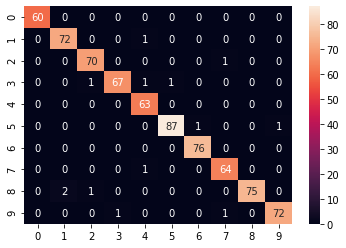

In [ ]:
cmat_svm = evaluation(y_test, svm_pred)
sns.heatmap(cmat_svm, annot=True)
plt.show()

We found that all of the evaluation metrics have higher scores! This means that SVM outperforms Logistic Regression. Interesting to note that the misclassification case for the case "*label=8 but prediction=1*" reduces from 3 to 2. Let's see what are the 2 misclassified cases:

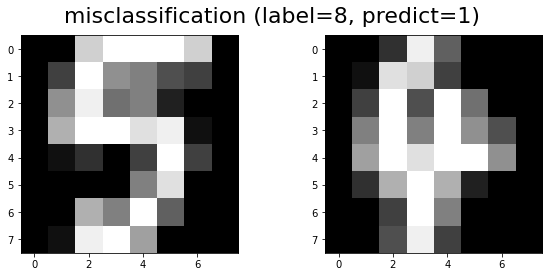

In [ ]:
mis_idx = []
for idx, (t, p) in enumerate(zip(y_test, svm_pred)):
  if t == 8 and p == 1:
    mis_idx.append(idx)

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
axes[0].imshow(X[mis_idx[0]].reshape((8, 8)), cmap="gray")
axes[1].imshow(X[mis_idx[1]].reshape((8, 8)), cmap="gray")
fig.suptitle("misclassification (label=8, predict=1)", size=22)
plt.show()

Compared to the result from Logistic Regression, now the "6-like" images (with actual label=8) has been correctly classified using the SVM!

**So far, SVM is the best model for the hand-written digits classification task.**

<h2><b><u>Model 3: Decision Tree</u></b></h2>

The Decision Tree is the most explainable model for us. It simply uses a hierarchical if-else statement to separate the data.

Yet, could it yields better performance? Let's check this out:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=100, random_state=0)
dt.fit(X_train_s, y_train)
dt_pred = dt.predict(X_test_s)

Accuracy: 0.83
Precision: 0.83
Recall: 0.83
AUROC: 0.91


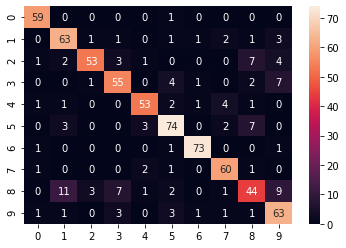

In [ ]:
cmat_dt = evaluation(y_test, dt_pred)
sns.heatmap(cmat_dt, annot=True)
plt.show()

Oops, the performance is lower than the Logistic Regression model.

Let's use the visualization tool to find some clues about such phenomenon:

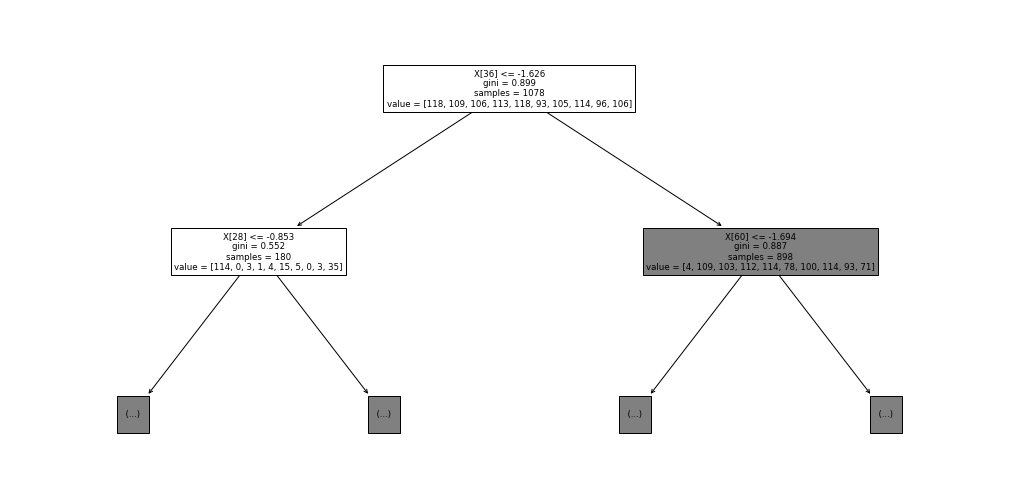

In [ ]:
from sklearn import tree
plt.gcf().set_size_inches(18, 9)
tree.plot_tree(dt, max_depth=1)
plt.show()

We see that a Decision Tree will make an if statement based on pixel values at certain locations. However, a digit in an 8x8 grid may sometimes be shifted or rotated according to the writer's preference. It's hard to define an absolute if-else statement for a digit recognition problem, since different writers may have different writing styles. Hence, the Decision Tree classifier may not be a proper method for classifying the hand-written digits dataset.

<h2><b><u>Model 4: Bagging Ensemble</u></b></h2>

The Bagging Ensemble method uses a pool of the same model with variation, and output a unique value using majority vote, etc. In general, it should yield better performance than its base estimator, since its hypothesis space is larger than the base estimator. To be more specific, the hypothesis space of its base estimator is just a special case when a Bagging Ensemble has identical parameters for each of its base estimator.

Let's see the actual performance of the Bagging Ensemble method. [By default](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), the base estimator for a Bagging Ensemble is the Decision Tree Classifier.

In [ ]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(random_state=0)
bag.fit(X_train_s, y_train)
bag_pred = bag.predict(X_test_s)

Accuracy: 0.92
Precision: 0.92
Recall: 0.92
AUROC: 0.96


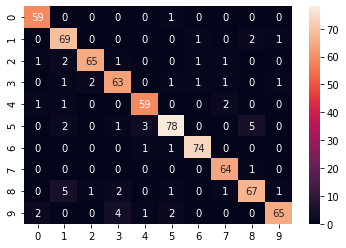

In [ ]:
cmat_bag = evaluation(y_test, bag_pred)
sns.heatmap(cmat_bag, annot=True)
plt.show()

As we can see, the Bagging Ensemble Classifier yields better performance compared to a single Decision Tree method. However, it still cannot compete with our baseline model.

<h2><b><u>Model 5: Random Forest</u></b></h2>

A Random Forest Classifier is a more general method compared to the bagging method, since it can sample a specific amount of features for any of its base estimators (i.e. Decision Tree). The reason to sample the features is to avoid overfitting on the test data. Because Random Forest has a larger hypothesis space compared to the Bagging method (specific case: sample all of the features for all trees), it should yield higher performance than the Bagging method if trained well.

Let's see its actual performance:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_s, y_train)
rf_pred = rf.predict(X_test_s)

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
AUROC: 0.99


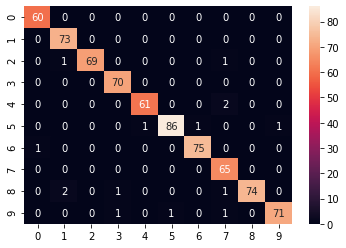

In [ ]:
cmat_rf = evaluation(y_test, rf_pred)
sns.heatmap(cmat_rf, annot=True)
plt.show()

As we can see, the performance is not only significantly better than the Bagging Ensemble and the single Decision Tree methods, but also closed to the SVM! As a proverb goes, "Two heads are better than one". Though a single Decision Tree cannot yield poor performance, the ensemble of them can outreach their limitations.

**So far, the SVM and Random Forest yield the best performance.**

<h2><b><u>Model 6: AdaBoost</u></b></h2>

AdaBoost is also an ensemble method, but instead of ensembling multiple independent models together, AdaBoost selects the hyperplane based on previous results for each iteration. Since it is a sequential method instead of a parallel method, it takes more time for optimization.

Let's see the performance of the AdaBoost Classifier. [By default](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), the base estimator for an AdaBoost is the Decision Tree Classifier.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(algorithm="SAMME", random_state=0)
ada.fit(X_train_s, y_train)
ada_pred = ada.predict(X_test_s)

Accuracy: 0.74
Precision: 0.75
Recall: 0.74
AUROC: 0.85


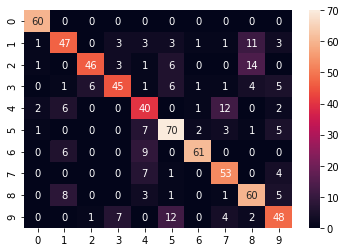

In [ ]:
cmat_ada = evaluation(y_test, ada_pred)
sns.heatmap(cmat_ada, annot=True)
plt.show()

Unfortunately, it yields the worst performance so far. Perhaps the reason may be due to the low capability of its default base estimator. Since Decision Tree is not good enough, let's replace its base estimator with a simple linear SVM:

In [ ]:
ada = AdaBoostClassifier(base_estimator=SVC(kernel="linear"), algorithm="SAMME", random_state=0)
ada.fit(X_train_s, y_train)
ada_pred = ada.predict(X_test_s)

Accuracy: 0.93
Precision: 0.93
Recall: 0.93
AUROC: 0.96


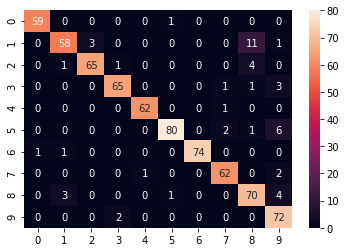

In [ ]:
cmat_ada = evaluation(y_test, ada_pred)
sns.heatmap(cmat_ada, annot=True)
plt.show()

Now the performance boosts, but the performance cannot even compete with SVM with RBF kernel. Of course, we can change the base estimators (SVM) into the RBF kernel version, but that loses the true meaning of the AdaBoost (i.e. combining **weak** classifiers together).

In addition, training AdaBoost with an SVM estimator is very time-consuming. Therefore, it is not recommended to use this method for classifying the hand-written digits dataset.

<h2><b><u>Model 7: Stacking Ensemble</u></b></h2>

Now, let's recap what we have done so far. In the hand-written digits classification task, the Linear Regression, SVM, and Random Forest method yields very good performance, and there are only few misclassified cases.

How about ensembling them altogether? In this section, Let's try to stack them into a single, ultimate classifier and use another Logistic Regression as the final estimator. Hopefully, it could eventually produce the best result.

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [("LR", lr), ("SVM", svm), ("RF", rf)]
stack = StackingClassifier(estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=0))
stack.fit(X_train_s, y_train)
stack_pred = stack.predict(X_test_s)

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
AUROC: 0.99


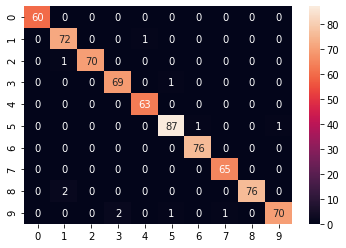

In [ ]:
cmat_stack = evaluation(y_test, stack_pred)
sns.heatmap(cmat_stack, annot=True)
plt.show()

That seems great, but it's hard for us to tell which model is the best because their performance are too closed. Therefore, let's plot their confusion matrixes together, and see which one has the highest True Positives:

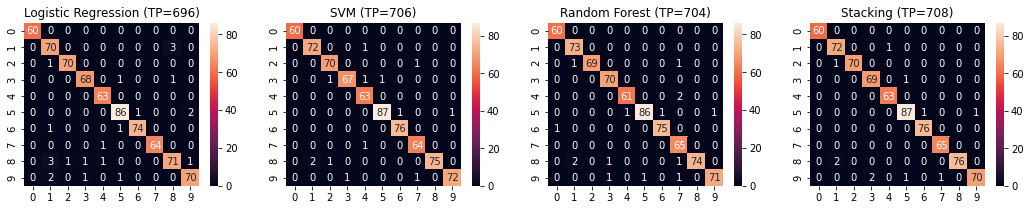

In [ ]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18, 3)
sns.heatmap(cmat_lr, ax=axes[0], annot=True)
sns.heatmap(cmat_svm, ax=axes[1], annot=True)
sns.heatmap(cmat_rf, ax=axes[2], annot=True)
sns.heatmap(cmat_stack, ax=axes[3], annot=True)

axes[0].set_title("Logistic Regression (TP={})".format(np.trace(cmat_lr)))
axes[1].set_title("SVM (TP={})".format(np.trace(cmat_svm)))
axes[2].set_title("Random Forest (TP={})".format(np.trace(cmat_rf)))
axes[3].set_title("Stacking (TP={})".format(np.trace(cmat_stack)))
plt.show()

Here the value of True Positives can be counted by computing the trace of the confusion matrixes. As we can see, the Stacking method has the highest True Positives. Therefore, **stacking strong classifiers together can further enhance the performance.**

<h2><b><u>Conclusions</u></b></h2>

From the above results, we observe:

1. The UCI ML hand-written digits dataset has 8x8 images features with an 1-digit label, and the classes are balanced.
2. Stacking (Logistic Regression + SVM + Random Forest) yields the best performance.
3. Bagging Ensemble yields better performance than a single Decision Tree, and Random Forest yields better performance than Bagging Ensemble. It is because the better one has a larger hypothesis space.
4. AdaBoost can increase performance by applying more complex base estimators, but the final result still cannot compete with our baseline model (i.e. Logistic Regression).

<h2><b><u>Future Works</u></b></h2>

So far, the AdaBoost has the worst performance. However, the reason why it underperforms the simple Logistic Regression remains unknown. We may need to dive deeper into the optimization history (i.e. each iteration) of the AdaBoost, but such task is too complicated to analyze regarding that the dataset has 64 dimensions for its features. We may need to use more advanced techniques for further investigation.